# Assignment 2

To be delivered until 2023/12/27 23:59:59.

## 1) Arduino

You will start by setting up a series of connections in order to extract some data with the Arduino. First make the connections as shown below. **Mind the direction of the temperature sensor. If you have an incorrect position, you will be connection the power to the ground and vice-versa and you will damage the sensor.** The photoresistor sensor on the other hand has no polarity.

<img src="https://github.com/guilhermejoaquim08/AA_Project/blob/master/laboratory/L4_Arduino/temp_photo_cropped.png?raw=1" width=1000/>

On this problem, you will read temperature and luminance from the sensors and print them on the serial.

**1)** Code an Arduino sketch, where the value of temperature and luminance are printed to the serial. For each serial print that you make, print the value of temperature, then a semicolon, then the value of luminance with a new line (use no whitespaces). You can do this by using three separate `Serial.print`, with the last one being a `Serial.println`. Print values 5 times per second (use the delay function to control this). Manually influence the readings of the sensors, by covering the photoresistor or shining light on it, and by lightly and carefully touching the temperature sensor to increase its temperature readings.

**Note that the temperature sensor appears not to be very reliable. Since the objective of this exercise is just to plot the results, this should not be an issue.**

**Copy and paste your arduino code below. You may use a python code cell, even though the code can not be run.**

*Hint: for the temperature value to be in celsius, divide the read value by 1024 and multiply it by 500. The luminance does not have to be converted*

In [ ]:
const int temperaturePin = A1;
const int lightPin = A0;

void setup() {
  // put your setup code here, to run once:
  Serial.begin(9600);

}

void loop() {
  // Read the analog value from the temperature sensor
  int rawTemperatureValue = analogRead(temperaturePin);

  // Convert the raw analog value to temperature in degrees Celsius
  float temperatureCelsius = (rawTemperatureValue / 1024.0) * 500.0;

  // Read the analog value from the light sensor
  int rawLightValue = analogRead(lightPin);

  // Print temperature and light values to the Serial Monitor
  Serial.print(temperatureCelsius);
  Serial.print(";");
  Serial.println(rawLightValue);

  // Add a delay to control the update rate (5 times per second)
  delay(200);
}

To import the data into Arduino, keep it running (the Serial Monitor must be closed in Arduino) and run the following code. Change the COM port to your own. This block of code will read 1000 values from the Serial. Given that each observation is taken every 0.2 seconds, it should take a minute and a half.

In [ ]:
import serial
import time

ser = serial.Serial('COM4', 9600, timeout=1)
time.sleep(2)

data = []
for i in range(500):
    line = ser.readline()
    if line:
        string = line.decode()
        data.append(string)

ser.close()

Convert the data into a pandas dataframe and save it in a csv file. Besides the value of temperature and luminance, also include the time, considering the first observation at $t=0$ and every observation 0.2 seconds after the previous one. **The file must be submitted in Fenix and included in your Github repo**.

In [ ]:
import pandas as pd

df = pd.DataFrame(data)
df.to_csv("Temeperature_Light.csv")

Plot the Temperature against time, the luminance against time and the temperature against the luminance.

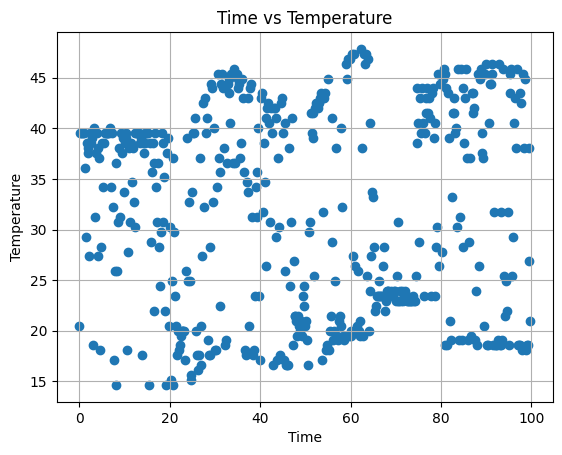

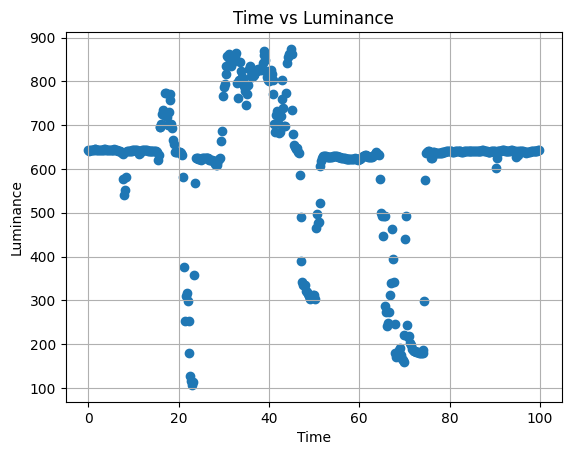

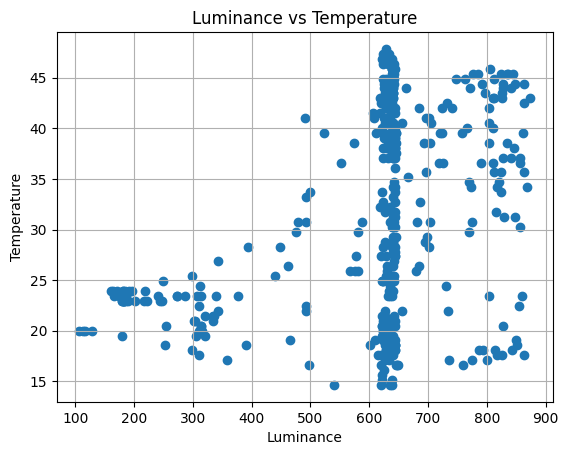

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Temeperature_Light.csv', header=None)

df[[1, 2]] = df[1].str.split(';', expand=True)

df[2] = df[2].str.replace(r'\r\n', '', regex=True)

df[0] = 0.2*df[0]
df[1] = pd.to_numeric(df[1])
df[2] = pd.to_numeric(df[2])

df.columns = ['Time','Temperature','Luminance']

df.dropna(inplace=True)

plt.scatter(df['Time'], df['Temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Time vs Temperature')
plt.grid(True)
plt.show()

plt.scatter(df['Time'], df['Luminance'])
plt.xlabel('Time')
plt.ylabel('Luminance')
plt.title('Time vs Luminance')
plt.grid(True)
plt.show()

plt.scatter(df['Luminance'], df['Temperature'])
plt.xlabel('Luminance')
plt.ylabel('Temperature')
plt.title('Luminance vs Temperature')
plt.grid(True)
plt.show()

## 2) Databases

For the databases part of this assignment, you will use the mimic-iii database from the laboratory session. Start by adding a few new tables to the database, using the SQL files included in the assignment's files. Open PGAdmin and connect to your mimic-iii database. **To properly load these tables, load the following files exactly and by the order presented.**

1) Run demographic.sql

2) Run lab_firstday.sql

You will now have to answer a few SQL questions.

**1.** Open the connection to your mimic-iii database. If you want, you can delete your credentials before submitting the assignment, but if you do so, please run the notebook first, for the results to be displayed.

In [ ]:
import psycopg2 as psql

conn = psql.connect(host='localhost',
                    database='mimic-iii',
                    #user='your_username',
                    #password='your_password',
                    user='postgres',
                    password='guilherme2002',
                    port=5432)

#Create a cursor object using the cursor() method
cursor = conn.cursor()

#Execute a SQL function using the execute() method
cursor.execute("select version()")

# Fetch a single row using fetchone() method
data = cursor.fetchone()
print("Connection established to: ", data)

OperationalError: ignored

**2.** Create a function that receives an SQL query and automatically opens a cursor, queries the database, extracts the columns, creates a pandas database, and closes the connections.

**3.** Query the table admissions filtering for admission type as emergency and insurance as private.

**4.** Query the table admissions, filtering for the same conditions as the previous exercise (admission type as emergency and insurance as private). Join the "drgcodes" table on the admission ID. Display only the columns regarding the subject id, admission id, time of death, and description of the drug.

**5.1.** Obtain the dataset for this problem, by running the SQL query below.

In [ ]:
query = "SELECT pivoted_lab.*," +\
                "gender as gender," +\
                "admission_age," +\
                "ethnicity_grouped as eth_grp," +\
                "hospital_expire_flag," +\
                "los_icu " +\
        "FROM demographics " +\
        "LEFT JOIN pivoted_lab " +\
        "ON demographics.icustay_id = pivoted_lab.icustay_id " +\
        "WHERE first_icu_stay = true"

**5.2.** Close the connection to your SQL server.

**5.3.** Prepare your dataset:

* Drop the ID columns of subject, admission and ICU stay.
* Drop columns with at least one NA value.
* Encode the categorical columns, the ethnicity and gender ('eth_grp', 'gender'). *Suggestion: use pd.get_dummies*
* Consider the column 'hospital_expire_flag' as the response and all remaining columns as the predictors.

**6.** Fit the following tree-based classifiers to the dataset. For each method:

* Perform k-fold cross validation to evaluate the models. Consider 10 folds.

* Plot the ROC curves for each fold, along with the mean ROC curve.

* Calculate the mean AUC.

**a.** Decision tree.

**b.** Random forest

**c.** Gradient Boosting

**7.1.** Perform a grid search cross-validation on the Gradient boosting methods, changing the value of the learning rate (0.01 to 0.5) and the number of estimators (50-500). Consider the mean AUC of the folds as the performance measure.

**7.2.** Plot a scatterplot of the learning rate versus the number of estimators, with the mean AUC as the color gradient.

**8.1.** Perform forward stepwise selection on the dataset. Use the best parameters of the gradient boosting method obtained in **7.1.**.

**8.2.** Compare and comment the results from **8.1.** with the features importance obtained through the grid search of queastion **7.1.**.

## 3) Theoretical Questions

**1.** Consider a dataset where best subset, forward stepwise and backward stepwise selection will be performed. For each of the 3 approaches, we obtain $p+1$ models, $p$ being the total number of predictors. This means that each approach has a model with 0 predictors, one with 1 predictor, one with 2 predictor, up until one model with $p$ predictors. Answer and justify the following questions:

**a)** Which of the three models with $k, \, \forall_{k \in [0,p]}$ predictors has the smallest training RSS?

In theory the best subset selection can achieve the smallest training RSS compared to forward and backward stepwise selection because it considers all possible combinations of predictors. Also the model containing all the predictors will always have the smallest RSS, meaning that the best subset selection will cover this option. It may also happen that the other methods choose the same model.

**b)** Which of the three models with $k, \, \forall_{k \in [0,p]}$ predictors has the smallest test RSS?

This is practically impossible to predict with no other data provided. There is a chance that best subset selection overfits in the test set, and one of the other method achieves a better test RSS, but we do not know if this happens based on the data we've been provided.

**c)** Evaluate the following statements with *true* or *false*. Justify your answers.

    i. The predictors in the k-variable model identified by forward stepwise selection are a subset of the predictors in the (k+1)-variable model identified by forward stepwise selection.

**True**\
Forward stepwise selection iteratively adds a predictor to a model based on its incremental contribution to a wanted metric. This ensures that the k-variable model identified by Forward stepwise selection will be a subset of (k+1)-variable model identified by Forward stepwise selection:



*   k-variable model: {1,2,3}
*   (k+1)-variable model: {1,2,3,4}



    ii. The predictors in the k-variable model identified by backward stepwise selection are a subset of the predictors in the (k + 1)-variable model identified by backward stepwise selection.

**True**\
Backward stepwise selection iteratively drops a predictor from the model based on its incremental contribution to a wanted metric. This ensures that k-variable model identified by Backward stepwise selection will always be a subset of (k+1)-variable model identified by Backward stepwise selection:



*   (k+1)-variable model: {1,2,3,4,5}
*   k-variable model: {1,2,4,5}



    iii. The predictors in the k-variable model identified by backward stepwise selection are a subset of the predictors in the (k + 1)-variable model identified by forward stepwise selection.

**False**\
Forward and Backward stepwise selection are independent methods with no direct relation. This means that we cannot for certain say that the k-variable model identified by Backward stepwise selection is always a subset of the (k+1)-variable model identified by Forward stepwise selection, eventhought this sometimes might apply.

    iv. The predictors in the k-variable model identified by forward stepwise selection are a subset of the predictors in the (k+1)-variable model identified by backward stepwise selection.

**False**\
Forward and Backward stepwise selection are independent methods with no direct relation. This means that we cannot for certain say that the k-variable model identified by Forward stepwise selection is always a subset of the (k+1)-variable model identified by Backward stepwise selection, eventhought this sometimes might apply.

    v. The predictors in the k-variable model identified by best subset selection are a subset of the predictors in the (k + 1)-variable model identified by best subset selection.

**False**\
Best subset selection, selects the best subset of predictors for each k, and the subsets are independent from each other. After this the method selects the best subset out of those. This means that the k-variable model identified by the best subset selection is not always the subset of (k+1)-variable model identified by best subset selection.

- k-variable model: {1,4,8}
- (k+1)-variable model: {1,3,4,9}

**2.** Ridge regression tends to give similar coefficient values to correlated variables, whereas lasso regression may give substantially different coefficients to correlated variables. This questions explores this property in a simplified setting.

Suppose that $n=2$, $p=2$, $x_{11} = x_{12}$, $x_{21} = x_{22}$. Moreover, suppose that $y_1 + y_2 = 0$ and $x_{11} + x_{21} = 0$ and $x_{12} + x_{22} = 0$, meaning that the estimate for the intercept in a least squares, ridge regression, or lasso regression is zero: $\hat{\beta} = 0$.

**a)** Write the ridge regression optimization problem in this setting.

The ridge regression formula that we try to minimize is:

$\sum_{i=1}^k (y_i - \hat{\beta}_0 - \sum_{j=1}^p \hat{\beta}_j x_{ij})^2 + λ ∑_{j=1}^p \hat{β}_j^2$

By expanding this formula with our values we get:\
$(y_1 - \hat{\beta}_0 - \hat{\beta}_1 x_{11} + \hat{\beta}_2 x_{12})^2+(y_2-\hat{\beta}_0-\hat{\beta}_1 x_{21} + \hat{\beta}_2 x_{22})^2 + λ( \hat{\beta}_1^2 + \hat{\beta}_2^2)$

We can now input $\hat{\beta}_0 = 0$ and $x_{11}=x_{12}=x_1$ and $x_{21}=x_{22}=x_2$:

$(y_1-\hat{\beta}_1 x_1 - \hat{\beta}_2 x_1)^2+(y_2 - \hat{\beta}_1 x_2 - \hat{\beta}_2 x_2)^2 + λ(\hat{\beta}_1^2 + \hat{\beta}_2^2)$

**b)** Prove that in this setting, the ridge *regression* coefficient estimates satisfy $\hat{\beta}_1 = \hat{\beta}_2$.

If we derive the remaining function with respect to $\hat{β}_1$, we get (after reduction):


$\hat{\beta}_1(x_1^2+x_2^2+\lambda)-x_1y_1+\hat{\beta}_2(x_1^2+x_2^2) - x_2y_2$


Now if we derive the remaining function from (a) with respect to $\hat{\beta}_2$, we get:\
$\hat{\beta}_1(x_1^2+x_2^2)-x_1y_1+\hat{\beta}_2(x_1^2+x_2^2+\lambda)-x_2y_2$


If we now set that these two derivatives are equal to zero, we can combine them and substract the following:


$\hat{\beta}_1(x_1^2+x_2^2+\lambda)-x_1y_1+\hat{\beta}_2(x_1^2+x_2^2) - x_2y_2 = \hat{\beta}_1(x_1^2+x_2^2)-x_1y_1+\hat{\beta}_2(x_1^2+x_2^2+\lambda)-x_2y_2$


$⇒\hat{\beta}_1λ=\hat{\beta}_2λ$


$⇒\hat{\beta}_1 = \hat{\beta}_2$



**c)** Write the lasso regression optimization problem in this setting.

The lasso regression formula that we try to minimize is:


$\sum_{i=1}^n(y_i-\hat{\beta_0}-∑_{j=1}^p \hat{\beta}_jx_{ij})^2+\lambda \sum_{j=1}^p\lvert\hat{\beta_j}\rvert$


By expanding this formula with our values we get:


$(y_1-\hat{\beta}_0-\hat{\beta}_1x_{11}-\hat{\beta}_2x_{12})^2+(y_2-\hat{\beta}_0-\hat{\beta}_1x_{21}\hat{\beta}_2x_{22})^2+\lambda(\lvert\hat{\beta}_1\rvert+\lvert\hat{\beta}_2\rvert)$


We can now input $\hat{\beta}_0 = 0$ and $x_{11}=x_{12}=x_1$ and $x_{21}=x_{22}=x_2$:


$(y_1 - \hat{\beta}_1x_1 - \hat{\beta}_2x_1)^2 + (y_2 - \hat{\beta}_1x_2 - \hat{\beta}_2x_2)^2 + \lambda(|\hat{\beta}_1| + |\hat{\beta}_2|).$

**d)** Prove that in this setting, the lasso regression coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique, meaning that there are many possible solutions to the optimization problem in (c). Describe these solutions.

Lets use the alternative form of the lasso optimization problem:

$(y_1 - \hat{\beta}_1x_1 - \hat{\beta}_2x_1)^2 + (y_2 - \hat{\beta}_1x_2 - \hat{\beta}_2x_2)^2\text{ subject to }|\hat{\beta}_1| + |\hat{\beta}_2|\le s$

When thinking geometrically, the lasso contraint takes a form that resembles a diamond centered in the origin of a $(\hat{\beta}_1,\hat{\beta}_2)$ plane. It intersects at a distance s from the origin. By now using the setting where $x_1+x_2=0$ (Combining rules) and $y_1+y_2=0$, we have to minimize the simplified expression of:

$2[y_1-(\hat{\beta}_1+\hat{\beta}_2)x^1]^2$

The optimization problem has a simple solution of $\hat{\beta}_1 + \hat{\beta}_2 = \frac{y_1}{x_1}$. This is geometrically a line parrarel to the edge of the diamond of the constraints. The solution to the original lasso are contours of the function showcased before, that touch the Lasso-diamond $\hat{\beta}_1+\hat{\beta}_2=s$. As both $\hat{\beta}_1$ and $\hat{\beta}_2$ vary along the line $\hat{\beta}_1+\hat{\beta}_2=\frac{y_1}{x_1}$, the contours touch the lasso-diamond edge at different points. Resulting from this the entire edge of $\hat{\beta}_1+\hat{\beta}_2=s$ is a potential solution to the lasso optimization problem. Thus meaning that the lasso optimization problem has a whole set of solution rather than only having one unique one.


**3.** Draw an example of a partition of two-dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions R1, R2,..., the cutpoints t1, t2,..., and so forth.

If you prefer you can draw it by hand or in any software and use a scan of it.

In [22]:
import matplotlib.pyplot as plt

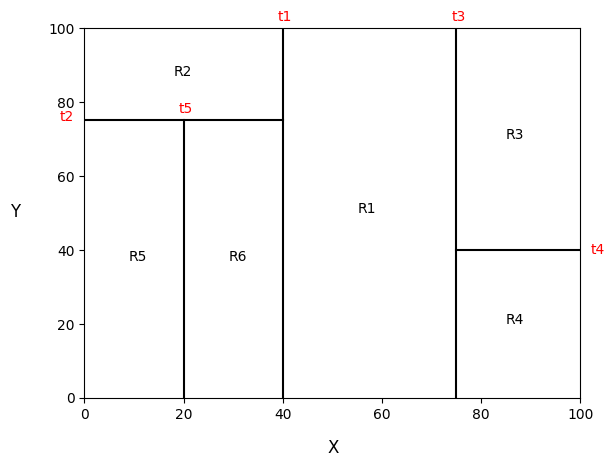

In [23]:
x1,y1 = [40,40], [0,100]
plt.plot(x1,y1,'k')
plt.text(39,102,'t1', color='red')
plt.text(55,50,'R1')

x2,y2 = [0,40], [75,75]
plt.plot(x2,y2,'k')
plt.text(-5,75, 't2', color='red')
plt.text(18,87,'R2')

x3,y3 = [75,75], [0,100]
plt.plot(x3,y3, 'k')
plt.text(74,102,'t3', color='red')
plt.text(85,70,'R3')

x4,y4 = [75,100], [40,40]
plt.plot(x4,y4, 'k')
plt.text(102,39,'t4', color='red')
plt.text(85,20,'R4')

x5,y5 = [20,20], [0,75]
plt.plot(x5,y5, 'k')
plt.text(19,77,'t5', color='red')
plt.text(9,37,'R5')
plt.text(29,37,'R6')

plt.text(-15,49,'Y',size=12)
plt.text(49,-15,'X',size=12)

plt.xlim([0,100])
plt.ylim([0,100])
plt.show()

And the corresponding decision tree:
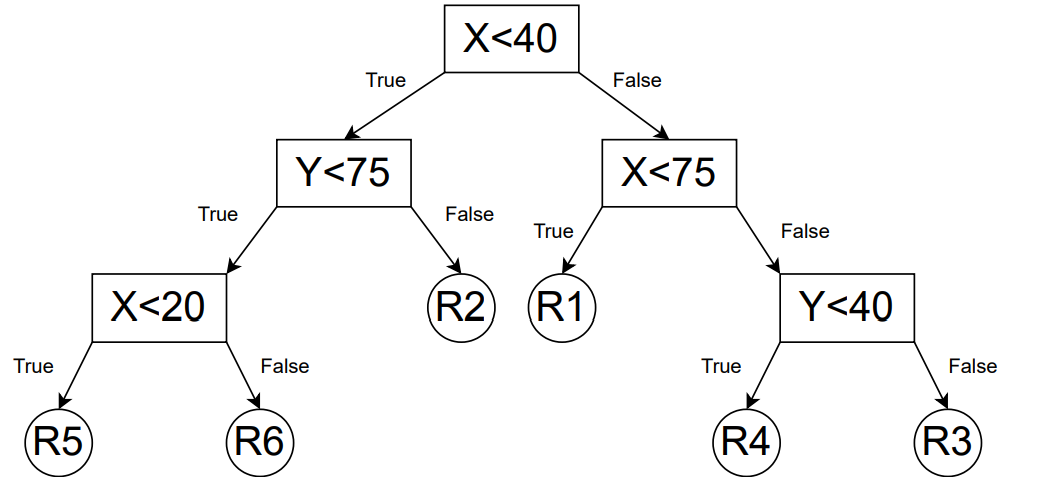

**4.** In 2 dimensions, a linear decision boundary takes the form $\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$. Consider a nn-linear decision boundary:

**a)** Sketch the curve

$$(1 + X_1)^2 + (2 - X_2)^2 = 4$$

Additionally, indicate on your sketch the set of points that verify the condition

$$(1 + X_1)^2 + (2 - X_2)^2 > 4$$

and the condition

$$(1 + X_1)^2 + (2 - X_2)^2 \leq 4$$

**b)** Suppose that a classifier assigns an observation to the blue class if $(1 + X_1)^2 + (2 - X_2)^2 > 4$ and to the red class otherwise. To what class are the following observations classified? (0,0), (-1,1), (2,2), (3,8)

**c)** Prove that while the decision boundary in (b) is not linear in terms of $X_1$ and $X_2$, it is linear in terms of $X_1$, $X_1^2$, $X_2$, and $X_2^2$.

# 4) Laboratory Questions

What are the advantages and disadvantages of relational dabases versus graph databases, and when should one type be preferred over the other?